In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sns
import math
from sklearn import metrics
from sklearn.metrics import confusion_matrix ,accuracy_score,  precision_score

Ładowanie i zapoznawanie się z danymi

In [2]:
data = pd.read_csv("train.csv", low_memory=False)
data.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [3]:
data.Credit_Score.unique() 

array(['Good', 'Standard', 'Poor'], dtype=object)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [5]:
data.shape

(100000, 28)

Podział zbioru

In [6]:
y = pd.Series(data['Credit_Score'])
X = data.drop(['Credit_Score'],axis=1)
# Train - budowa, test - zbior testowy dla budowy, val - zbiór dla validacji
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=123
)
X_train, X_test, y_train, y_test = train_test_split(
     X_train, y_train, test_size=0.2, random_state=123
)

Usuwanie kolumn i czyszczenie zbioru

In [7]:
def create_df(X,y):
  return X.join(y)

def drop_columns(df):
  drop_cols = ['ID','Name','SSN']
  df_dropped = df.drop(drop_cols , axis=1)
  return df_dropped

In [8]:
Train = create_df(X_train,y)
Train_dropped = drop_columns(Train)

In [9]:
for i in Train_dropped:
  print('\n',i,Train_dropped[i].unique())


 Customer_ID ['CUS_0x48ca' 'CUS_0xab2b' 'CUS_0xc5f8' ... 'CUS_0xc730' 'CUS_0x67cb'
 'CUS_0x59b5']

 Month ['February' 'June' 'April' 'May' 'August' 'March' 'July' 'January']

 Age ['40' '35' '21' ... '5195' '2181' '1512']

 Occupation ['_______' 'Entrepreneur' 'Musician' 'Manager' 'Mechanic' 'Journalist'
 'Architect' 'Engineer' 'Writer' 'Accountant' 'Doctor' 'Teacher'
 'Developer' 'Media_Manager' 'Scientist' 'Lawyer']

 Annual_Income ['40878.85' '31985.64_' '19998.33' ... '38750.41_' '68489.16_'
 '10796916.0']

 Monthly_Inhand_Salary [3440.57083333 2537.47       1810.5275     ... 1389.81041667 1209.70458333
 1086.48605979]

 Num_Bank_Accounts [   0    5    8    3    4    7    9    6   10    2    1   -1  803  448
 1075   11 1611  351  239  697  868  738 1481 1257 1763 1647  135  549
 1724  885  912  385 1624 1235 1137  761  695   83  802  886 1539  443
  809 1096  854 1632 1748  511  540 1447 1766 1195   34 1727 1041   35
  690 1784  572  481  991 1551   41  561  368 1534  624  232 157

In [10]:
def clean_records(df):
  clean = df.copy()
  pattern = "\\`*_{}[]()>#@+!$:;%"
  num_columns = ['Age', 'Monthly_Inhand_Salary','Delay_from_due_date','Num_of_Delayed_Payment','Outstanding_Debt',
           'Total_EMI_per_month','Monthly_Balance','Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
           'Interest_Rate', 'Num_of_Loan', 'Changed_Credit_Limit', 'Credit_Utilization_Ratio', 'Amount_invested_monthly', 'Num_Credit_Inquiries']
  str_columns = ['Month','Occupation','Credit_History_Age','Payment_of_Min_Amount', 'Type_of_Loan', 'Credit_Mix', 'Payment_Behaviour']
  for i in num_columns:
    for c in pattern:
      clean[i] = clean[i].astype(str).str.replace(c,'')

  for i in str_columns:
    for c in pattern:
      clean[i] = clean[i].replace(c,'')
  return clean


In [11]:
Train_clean_records = clean_records(Train_dropped)
Train_clean_records.head()

C:\Users\sebas\AppData\Local\Temp\ipykernel_25984\1508392769.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  clean[i] = clean[i].astype(str).str.replace(c,'')


,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
98425,CUS_0x48ca,February,40,_______,40878.85,3440.570833333333,0,5,11,4,...,Good,1360.31,26.81701555338201,24 Years and 0 Months,No,105.01709131492088,381.3557333047378,Low_spent_Small_value_payments,147.68425871367467,Good
20877,CUS_0xab2b,June,35,Entrepreneur,31985.64,2537.47,5,6,11,4,...,Standard,2615.0,28.991281345294343,5 Years and 8 Months,Yes,65.83466693482337,41.359838924330774,High_spent_Medium_value_payments,396.5524941408458,Poor
74091,CUS_0xc5f8,April,21,Musician,19998.33,1810.5275,8,6,12,3,...,Standard,1035.7,38.51756452024465,15 Years and 8 Months,Yes,42.94652501844877,179.15786414156628,Low_spent_Small_value_payments,248.94836083998496,Standard
9412,CUS_0x333c,May,20,Manager,46640.82,3824.735,3,4,13,3,...,,816.11,35.10770374043042,29 Years and 9 Months,No,75.53576696978119,92.49321517147406,High_spent_Medium_value_payments,464.4445178587448,Good
10687,CUS_0xabc6,August,26,Mechanic,20380.51,1854.375833333333,8,3,20,5,...,Standard,153.7,34.59073976080707,13 Years and 8 Months,Yes,57.299498128700144,170.10406404178968,Low_spent_Large_value_payments,228.03402116284352,Standard


In [12]:
def Credit_History_Age_trasform(df):
  CHA_transform = df.copy()
  CHA_transform['Credit_History_Age'] = CHA_transform['Credit_History_Age'].astype(str).str.replace(' Years and ','.')
  CHA_transform['Credit_History_Age'] = CHA_transform['Credit_History_Age'].astype(str).str.replace('Months','')

  for i in CHA_transform.Credit_History_Age.index:
    if CHA_transform.Credit_History_Age[i][-3] == ".":
       CHA_transform.Credit_History_Age[i] = str(CHA_transform.Credit_History_Age[i]).replace(".", ".0")

  CHA_transform['Credit_History_Age'] = CHA_transform['Credit_History_Age'].astype(float)
  CHA_transform['Credit_History_Age'] = (CHA_transform['Credit_History_Age'] % 1 * 100 + CHA_transform['Credit_History_Age'] // 1) * 12
  return CHA_transform

In [13]:
Train_CHA_transformed = Credit_History_Age_trasform(Train_clean_records)
Train_CHA_transformed.Credit_History_Age

98425    288.0
20877    156.0
74091    276.0
9412     456.0
10687    252.0
         ...  
31550    396.0
95515    276.0
30594    288.0
66172    276.0
49371    336.0
Name: Credit_History_Age, Length: 64000, dtype: float64

<AxesSubplot:>

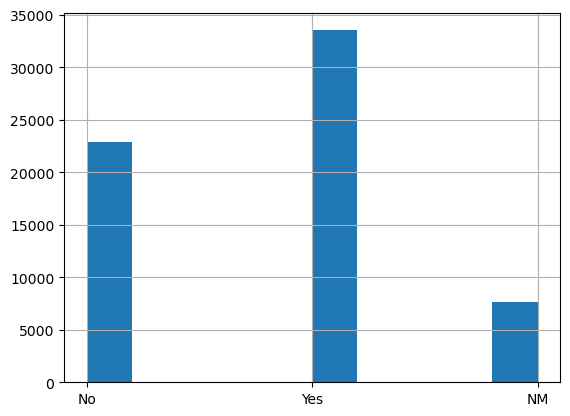

In [14]:
Train_CHA_transformed.Payment_of_Min_Amount.hist()

Kodowanie kolumn

In [15]:
def colums_encoding(df):

    df["Payment_Behaviour"] = df["Payment_Behaviour"].replace('!@9#%8', 'Unknown_spent_Unknown_value_payments')
    split_payment = lambda x:  ([x.split("_")[0], x.split("_")[2]] if (x is not None) else ["Unknown", "Unknown"])
    df["Payment_Behaviour"] = df["Payment_Behaviour"].apply(split_payment)
    df[["Spending_Behaviour", "Value_Payments"]] = pd.DataFrame(df["Payment_Behaviour"].tolist(), index=df.index)
    spending_dict = {'Low':0, 'High':1, 'Unknown':float('nan')}
    value_dict = {'Small':0, 'Medium':1, 'Large':2,  'Unknown':float('nan')}
    df['Spending_Behaviour'] = df['Spending_Behaviour'].map(spending_dict)
    df['Value_Payments'] = df['Value_Payments'].map(value_dict)
    del df["Payment_Behaviour"]

    dict_target={'Poor': "0", 
          "Standard":"1", 
          "Good":"2"}
    df.Credit_Score = df.Credit_Score.map(dict_target).astype(float)

    df = pd.get_dummies(df, prefix='Minimal', columns=['Payment_of_Min_Amount'], drop_first=False)
    return df

In [16]:
Train_encoded = colums_encoding(Train_CHA_transformed)
Train_encoded.head()

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Score,Spending_Behaviour,Value_Payments,Minimal_NM,Minimal_No,Minimal_Yes
98425,CUS_0x48ca,February,40,_______,40878.85,3440.570833333333,0,5,11,4,...,288.0,105.01709131492088,381.3557333047378,147.68425871367467,2.0,0.0,0.0,0,1,0
20877,CUS_0xab2b,June,35,Entrepreneur,31985.64,2537.47,5,6,11,4,...,156.0,65.83466693482337,41.359838924330774,396.5524941408458,0.0,1.0,1.0,0,0,1
74091,CUS_0xc5f8,April,21,Musician,19998.33,1810.5275,8,6,12,3,...,276.0,42.94652501844877,179.15786414156628,248.94836083998496,1.0,0.0,0.0,0,0,1
9412,CUS_0x333c,May,20,Manager,46640.82,3824.735,3,4,13,3,...,456.0,75.53576696978119,92.49321517147406,464.4445178587448,2.0,1.0,1.0,0,1,0
10687,CUS_0xabc6,August,26,Mechanic,20380.51,1854.375833333333,8,3,20,5,...,252.0,57.299498128700144,170.10406404178968,228.03402116284352,1.0,0.0,2.0,0,0,1


In [17]:
Train_encoded.dtypes

Customer_ID                  object
Month                        object
Age                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary        object
Num_Bank_Accounts            object
Num_Credit_Card              object
Interest_Rate                object
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date          object
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries         object
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio     object
Credit_History_Age          float64
Total_EMI_per_month          object
Amount_invested_monthly      object
Monthly_Balance              object
Credit_Score                float64
Spending_Behaviour          float64
Value_Payments              float64
Minimal_NM                    uint8
Minimal_No                    uint8
Minimal_Yes                 

In [18]:
def encoding_to_num(df):
  df_encoding_int = df.copy()
  columns = ['Age', 'Monthly_Inhand_Salary','Delay_from_due_date','Num_of_Delayed_Payment','Outstanding_Debt',
             'Total_EMI_per_month','Monthly_Balance','Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
             'Interest_Rate', 'Num_of_Loan', 'Credit_Utilization_Ratio', 'Amount_invested_monthly', "Changed_Credit_Limit", "Num_Credit_Inquiries"]
  df_encoding_int.Changed_Credit_Limit = [str(i or np.NaN) for i in df_encoding_int.Changed_Credit_Limit]
  for i in columns:
    df_encoding_int[i] = df_encoding_int[i].astype(float)

  
  return df_encoding_int

In [19]:
Train_encoded_int = encoding_to_num(Train_encoded)
Train_encoded_int['Type_of_Loan'] = Train_encoded_int['Type_of_Loan'].astype(str).str.replace('and ','')
Train_encoded_int['Type_of_Loan'] = Train_encoded_int['Type_of_Loan'].astype(str).str.replace(' Loan','')
Train_encoded_int['Type_of_Loan'] = Train_encoded_int['Type_of_Loan'].astype(str).str.replace('nan','nany')
Train_encoded_int.dtypes

Customer_ID                  object
Month                        object
Age                         float64
Occupation                   object
Annual_Income               float64
Monthly_Inhand_Salary       float64
Num_Bank_Accounts           float64
Num_Credit_Card             float64
Interest_Rate               float64
Num_of_Loan                 float64
Type_of_Loan                 object
Delay_from_due_date         float64
Num_of_Delayed_Payment      float64
Changed_Credit_Limit        float64
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt            float64
Credit_Utilization_Ratio    float64
Credit_History_Age          float64
Total_EMI_per_month         float64
Amount_invested_monthly     float64
Monthly_Balance             float64
Credit_Score                float64
Spending_Behaviour          float64
Value_Payments              float64
Minimal_NM                    uint8
Minimal_No                    uint8
Minimal_Yes                 

In [20]:
def encoding_columns_2(df):
  df_drop = df.copy()
  dict_target={'Bad': 0, 
          "Standard":1, 
          "Good":2,
          "":float('nan')}
  df_drop.Credit_Mix = df_drop.Credit_Mix.map(dict_target).astype(float)


  dict_target={'January': 1, 
          "February":2, 
          "March":3,
          "April":4,
          "May":5,
          "June":6,
          "July":7,
          "August":8,
          "September":9,
          "October":10,
          "November":11,
          "December":12}


  df_drop.Month = df_drop.Month.map(dict_target).astype(float)
  sin_values = [math.sin((2*math.pi*x)/12) for x in list(df_drop.Month)]
  cos_values = [math.cos((2*math.pi*x)/12) for x in list(df_drop.Month)]
  df_drop = df_drop.assign(Month_sin = sin_values, Month_cos = cos_values)
  df_drop = df_drop.drop("Month", axis = 1)


  
  text = ""
  for i in Train_encoded_int.Type_of_Loan:
    text = text + i + ","
  
  texting = list(text.split(","))
  for i in range(len(texting)):
    texting[i] = texting[i].strip()
  texting = list(set(texting))
  try:
    texting.remove('')
  except ValueError:
    pass
  
  try:
    texting.remove('nany')
  except ValueError:
    pass
  
  for i in texting:
    x = []
    for j in df_drop.Type_of_Loan:
      x.append(str(j).count(i))
    df_drop[i] = x
  
  df_drop = df_drop.drop("Type_of_Loan", axis = 1)


  return df_drop

In [21]:
Train_dropped = encoding_columns_2(Train_encoded_int)

In [22]:
Train_dropped.Occupation.value_counts()

_______          4567
Lawyer           4194
Scientist        4117
Developer        4101
Architect        4087
Engineer         4028
Media_Manager    4010
Accountant       4001
Mechanic         3964
Teacher          3926
Journalist       3896
Entrepreneur     3879
Doctor           3841
Writer           3817
Musician         3790
Manager          3782
Name: Occupation, dtype: int64

In [23]:
def occupation_agg(df):
  df_agg = df.copy()
  df_agg['Occupation'] = df_agg['Occupation'].astype(str).str.replace('_______','Other')
  df_agg = pd.get_dummies(df_agg, prefix='Occupation', columns=['Occupation'], drop_first=False)
  df_agg = df_agg.drop_duplicates()
  return df_agg

In [24]:
Train_occ_agg = occupation_agg(Train_dropped)
Train_occ_agg.dtypes

Customer_ID                  object
Age                         float64
Annual_Income               float64
Monthly_Inhand_Salary       float64
Num_Bank_Accounts           float64
Num_Credit_Card             float64
Interest_Rate               float64
Num_of_Loan                 float64
Delay_from_due_date         float64
Num_of_Delayed_Payment      float64
Changed_Credit_Limit        float64
Num_Credit_Inquiries        float64
Credit_Mix                  float64
Outstanding_Debt            float64
Credit_Utilization_Ratio    float64
Credit_History_Age          float64
Total_EMI_per_month         float64
Amount_invested_monthly     float64
Monthly_Balance             float64
Credit_Score                float64
Spending_Behaviour          float64
Value_Payments              float64
Minimal_NM                    uint8
Minimal_No                    uint8
Minimal_Yes                   uint8
Month_sin                   float64
Month_cos                   float64
Debt Consolidation          

In [25]:
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

Zamiana nulli

In [26]:
Train_swaped = swap_columns(Train_occ_agg, 'Credit_Score', 'Occupation_Writer')
Train_swaped.isnull().sum()

Customer_ID                     0
Age                             0
Annual_Income                   0
Monthly_Inhand_Salary        9515
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Delay_from_due_date             0
Num_of_Delayed_Payment       4460
Changed_Credit_Limit         1356
Num_Credit_Inquiries         1271
Credit_Mix                  12976
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           5824
Total_EMI_per_month             0
Amount_invested_monthly      2885
Monthly_Balance               735
Occupation_Writer               0
Spending_Behaviour           4936
Value_Payments               4936
Minimal_NM                      0
Minimal_No                      0
Minimal_Yes                     0
Month_sin                       0
Month_cos                       0
Debt Consolidation              0
Auto                            0
Student       

In [27]:
def fill_missing_values(df):
  df_na = df.copy()

  
  cols = list(df_na.columns.values)
  cols.remove('Customer_ID')
  cols.remove('Credit_Score')
  for i in cols:
    df_na[i] = df_na[i].fillna(df_na.groupby('Customer_ID')[i].transform("median"))
    df_na[i].fillna(Train_swaped[i].median(), inplace = True)
  df_na = df_na.drop("Customer_ID", axis = 1)

  
  return df_na

Korelacje i outliery

<AxesSubplot:>

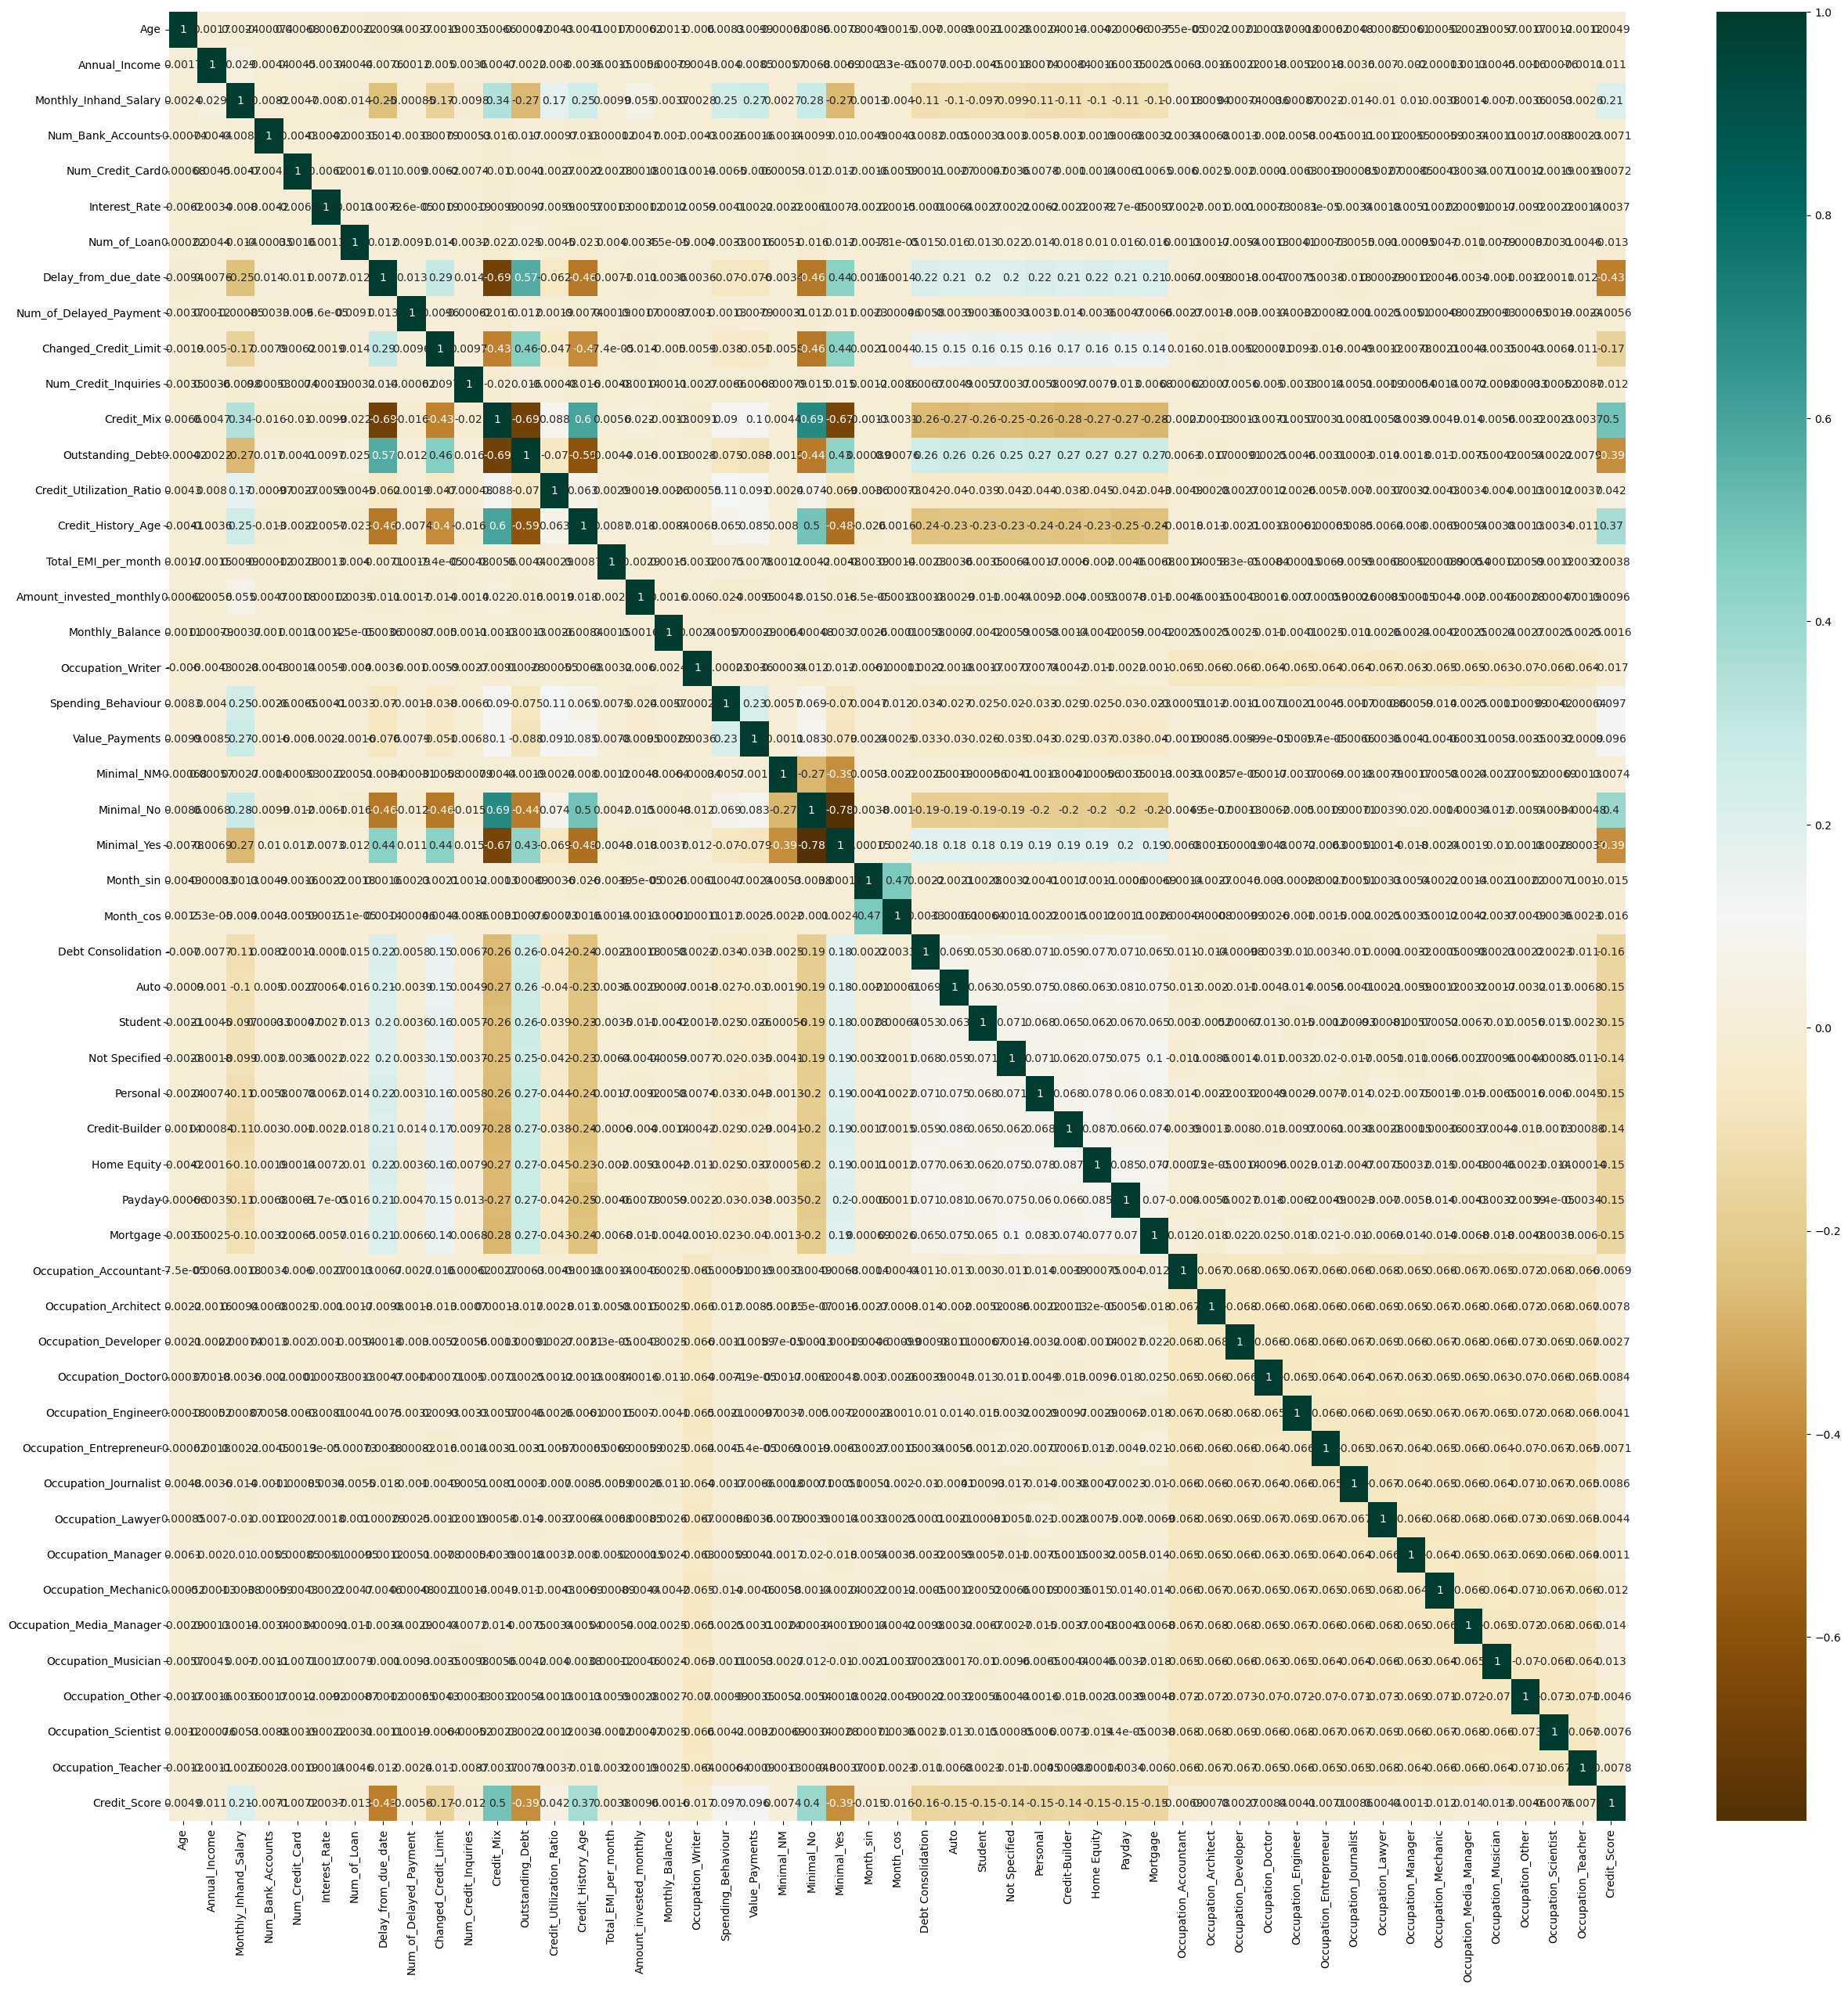

In [28]:
Train_na = fill_missing_values(Train_swaped)
corr_matrix = Train_na.corr("pearson")
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix,cmap="BrBG",annot=True)

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Annual_Income'}>,
        <AxesSubplot:title={'center':'Monthly_Inhand_Salary'}>,
        <AxesSubplot:title={'center':'Num_Bank_Accounts'}>],
       [<AxesSubplot:title={'center':'Num_Credit_Card'}>,
        <AxesSubplot:title={'center':'Interest_Rate'}>,
        <AxesSubplot:title={'center':'Num_of_Loan'}>,
        <AxesSubplot:title={'center':'Delay_from_due_date'}>],
       [<AxesSubplot:title={'center':'Num_of_Delayed_Payment'}>,
        <AxesSubplot:title={'center':'Changed_Credit_Limit'}>,
        <AxesSubplot:title={'center':'Num_Credit_Inquiries'}>,
        <AxesSubplot:title={'center':'Credit_Mix'}>],
       [<AxesSubplot:title={'center':'Outstanding_Debt'}>,
        <AxesSubplot:title={'center':'Credit_Utilization_Ratio'}>,
        <AxesSubplot:title={'center':'Credit_History_Age'}>,
        <AxesSubplot:title={'center':'Total_EMI_per_month'}>],
       [<AxesSubplot:title={'center':'Amount_in

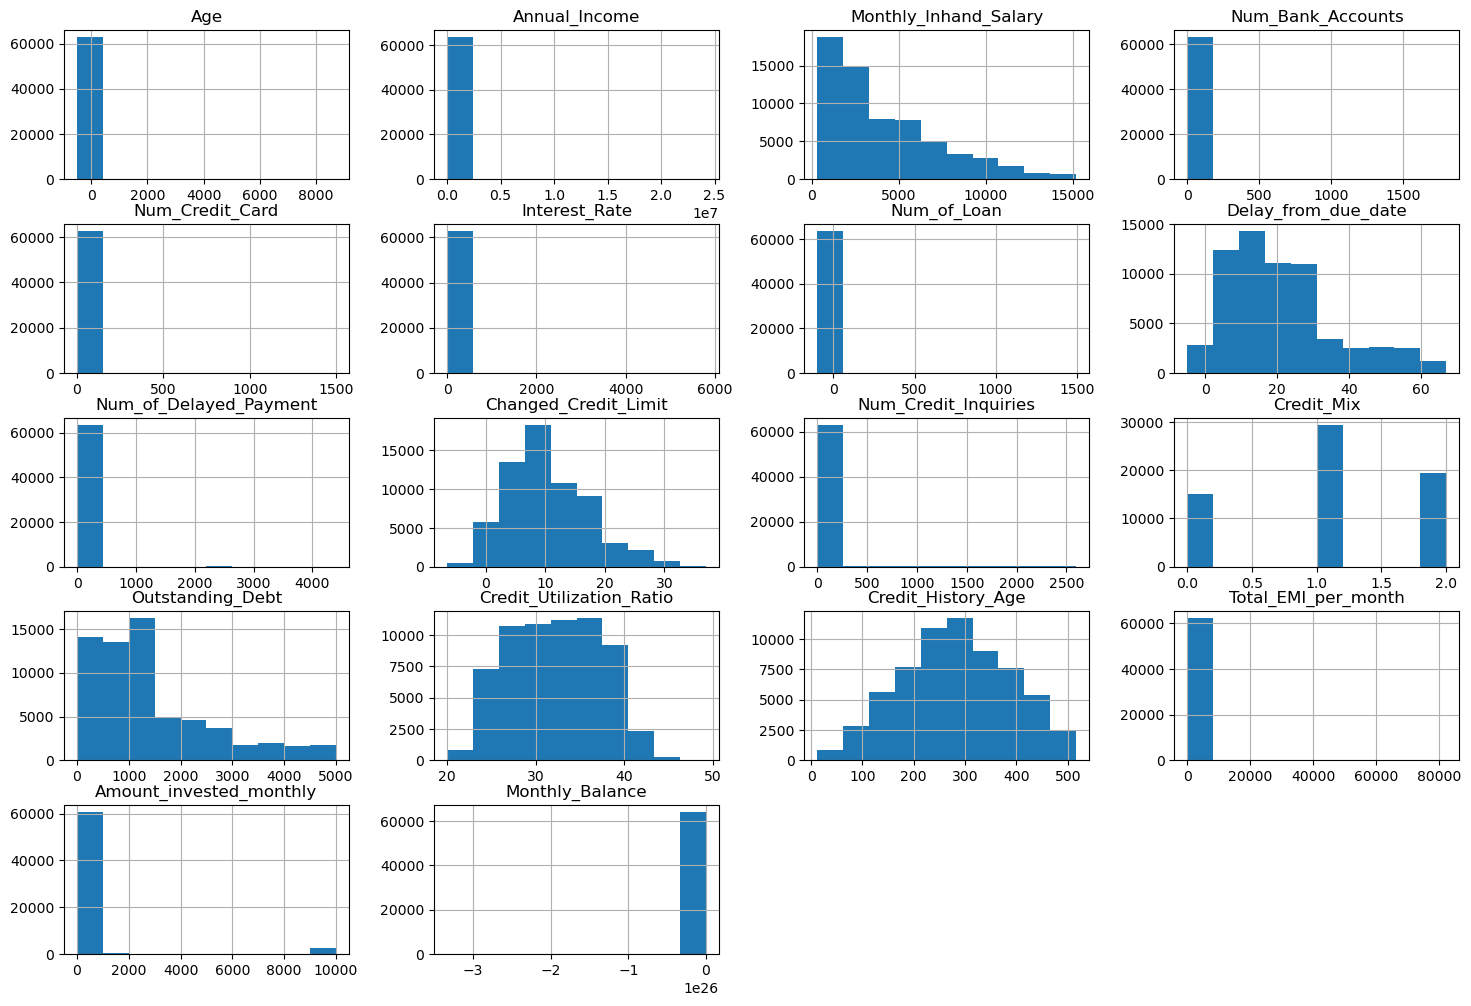

In [29]:
Train_na.loc[:,"Age":"Monthly_Balance"].hist(figsize = (18,12))


In [30]:
def outliers_agg(df):
  names = ["Age", "Annual_Income", "Num_Bank_Accounts", "Num_of_Delayed_Payment",
             "Monthly_Balance", "Num_Credit_Inquiries"]
  df_agg = df.copy()
  for i in names:
    upper_lim = Train_na[i].quantile(.98)
    lower_lim = Train_na[i].quantile(.02)
    df_agg[i] = np.where(df_agg[i] < lower_lim, lower_lim,
                   np.where(df_agg[i]>upper_lim, upper_lim,
                    df_agg[i]))
    
  names = ['Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Total_EMI_per_month']  
  for i in names:
    upper_lim = Train_na[i].quantile(.96)
    lower_lim = Train_na[i].quantile(.04)
    df_agg[i] = np.where(df_agg[i] < lower_lim, lower_lim,
                   np.where(df_agg[i]>upper_lim, upper_lim,
                    df_agg[i]))
    
  
  upper_lim = Train_na['Amount_invested_monthly'].quantile(.955)
  lower_lim = Train_na['Amount_invested_monthly'].quantile(.045)
  df_agg['Amount_invested_monthly'] = np.where(df_agg['Amount_invested_monthly'] < lower_lim, lower_lim,
                   np.where(df_agg['Amount_invested_monthly']>upper_lim, upper_lim,
                    df_agg['Amount_invested_monthly']))

  return df_agg

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Annual_Income'}>,
        <AxesSubplot:title={'center':'Monthly_Inhand_Salary'}>,
        <AxesSubplot:title={'center':'Num_Bank_Accounts'}>],
       [<AxesSubplot:title={'center':'Num_Credit_Card'}>,
        <AxesSubplot:title={'center':'Interest_Rate'}>,
        <AxesSubplot:title={'center':'Num_of_Loan'}>,
        <AxesSubplot:title={'center':'Delay_from_due_date'}>],
       [<AxesSubplot:title={'center':'Num_of_Delayed_Payment'}>,
        <AxesSubplot:title={'center':'Changed_Credit_Limit'}>,
        <AxesSubplot:title={'center':'Num_Credit_Inquiries'}>,
        <AxesSubplot:title={'center':'Credit_Mix'}>],
       [<AxesSubplot:title={'center':'Outstanding_Debt'}>,
        <AxesSubplot:title={'center':'Credit_Utilization_Ratio'}>,
        <AxesSubplot:title={'center':'Credit_History_Age'}>,
        <AxesSubplot:title={'center':'Total_EMI_per_month'}>],
       [<AxesSubplot:title={'center':'Amount_in

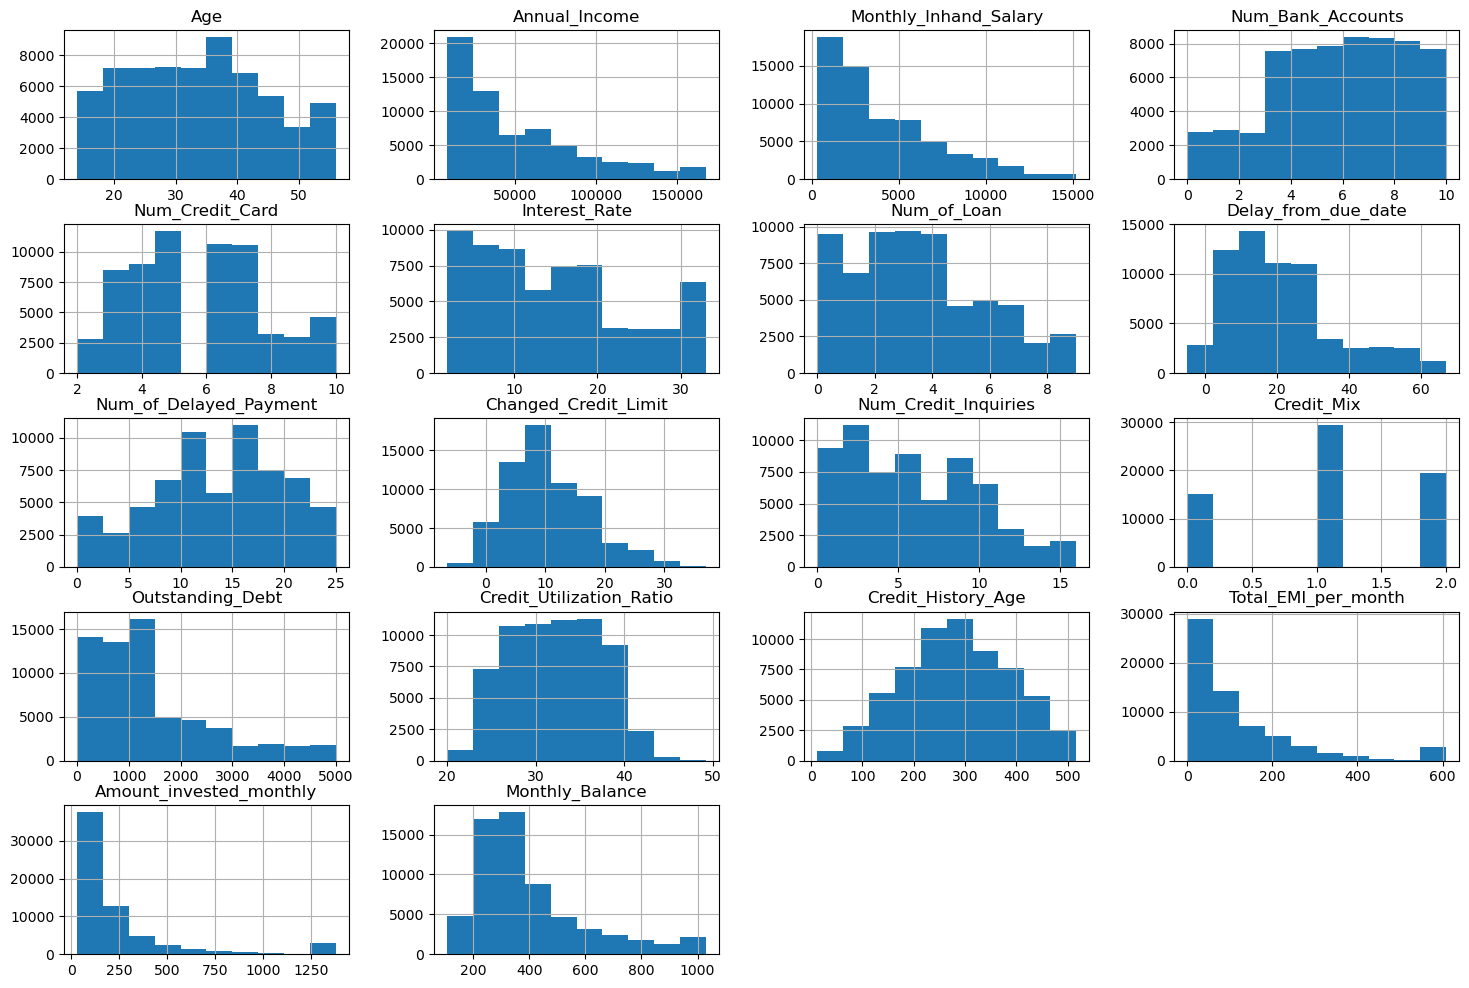

In [31]:
Train_outliers = outliers_agg(Train_na)
Train_outliers.loc[:,"Age":"Monthly_Balance"].hist(figsize = (18,12))

<AxesSubplot:>

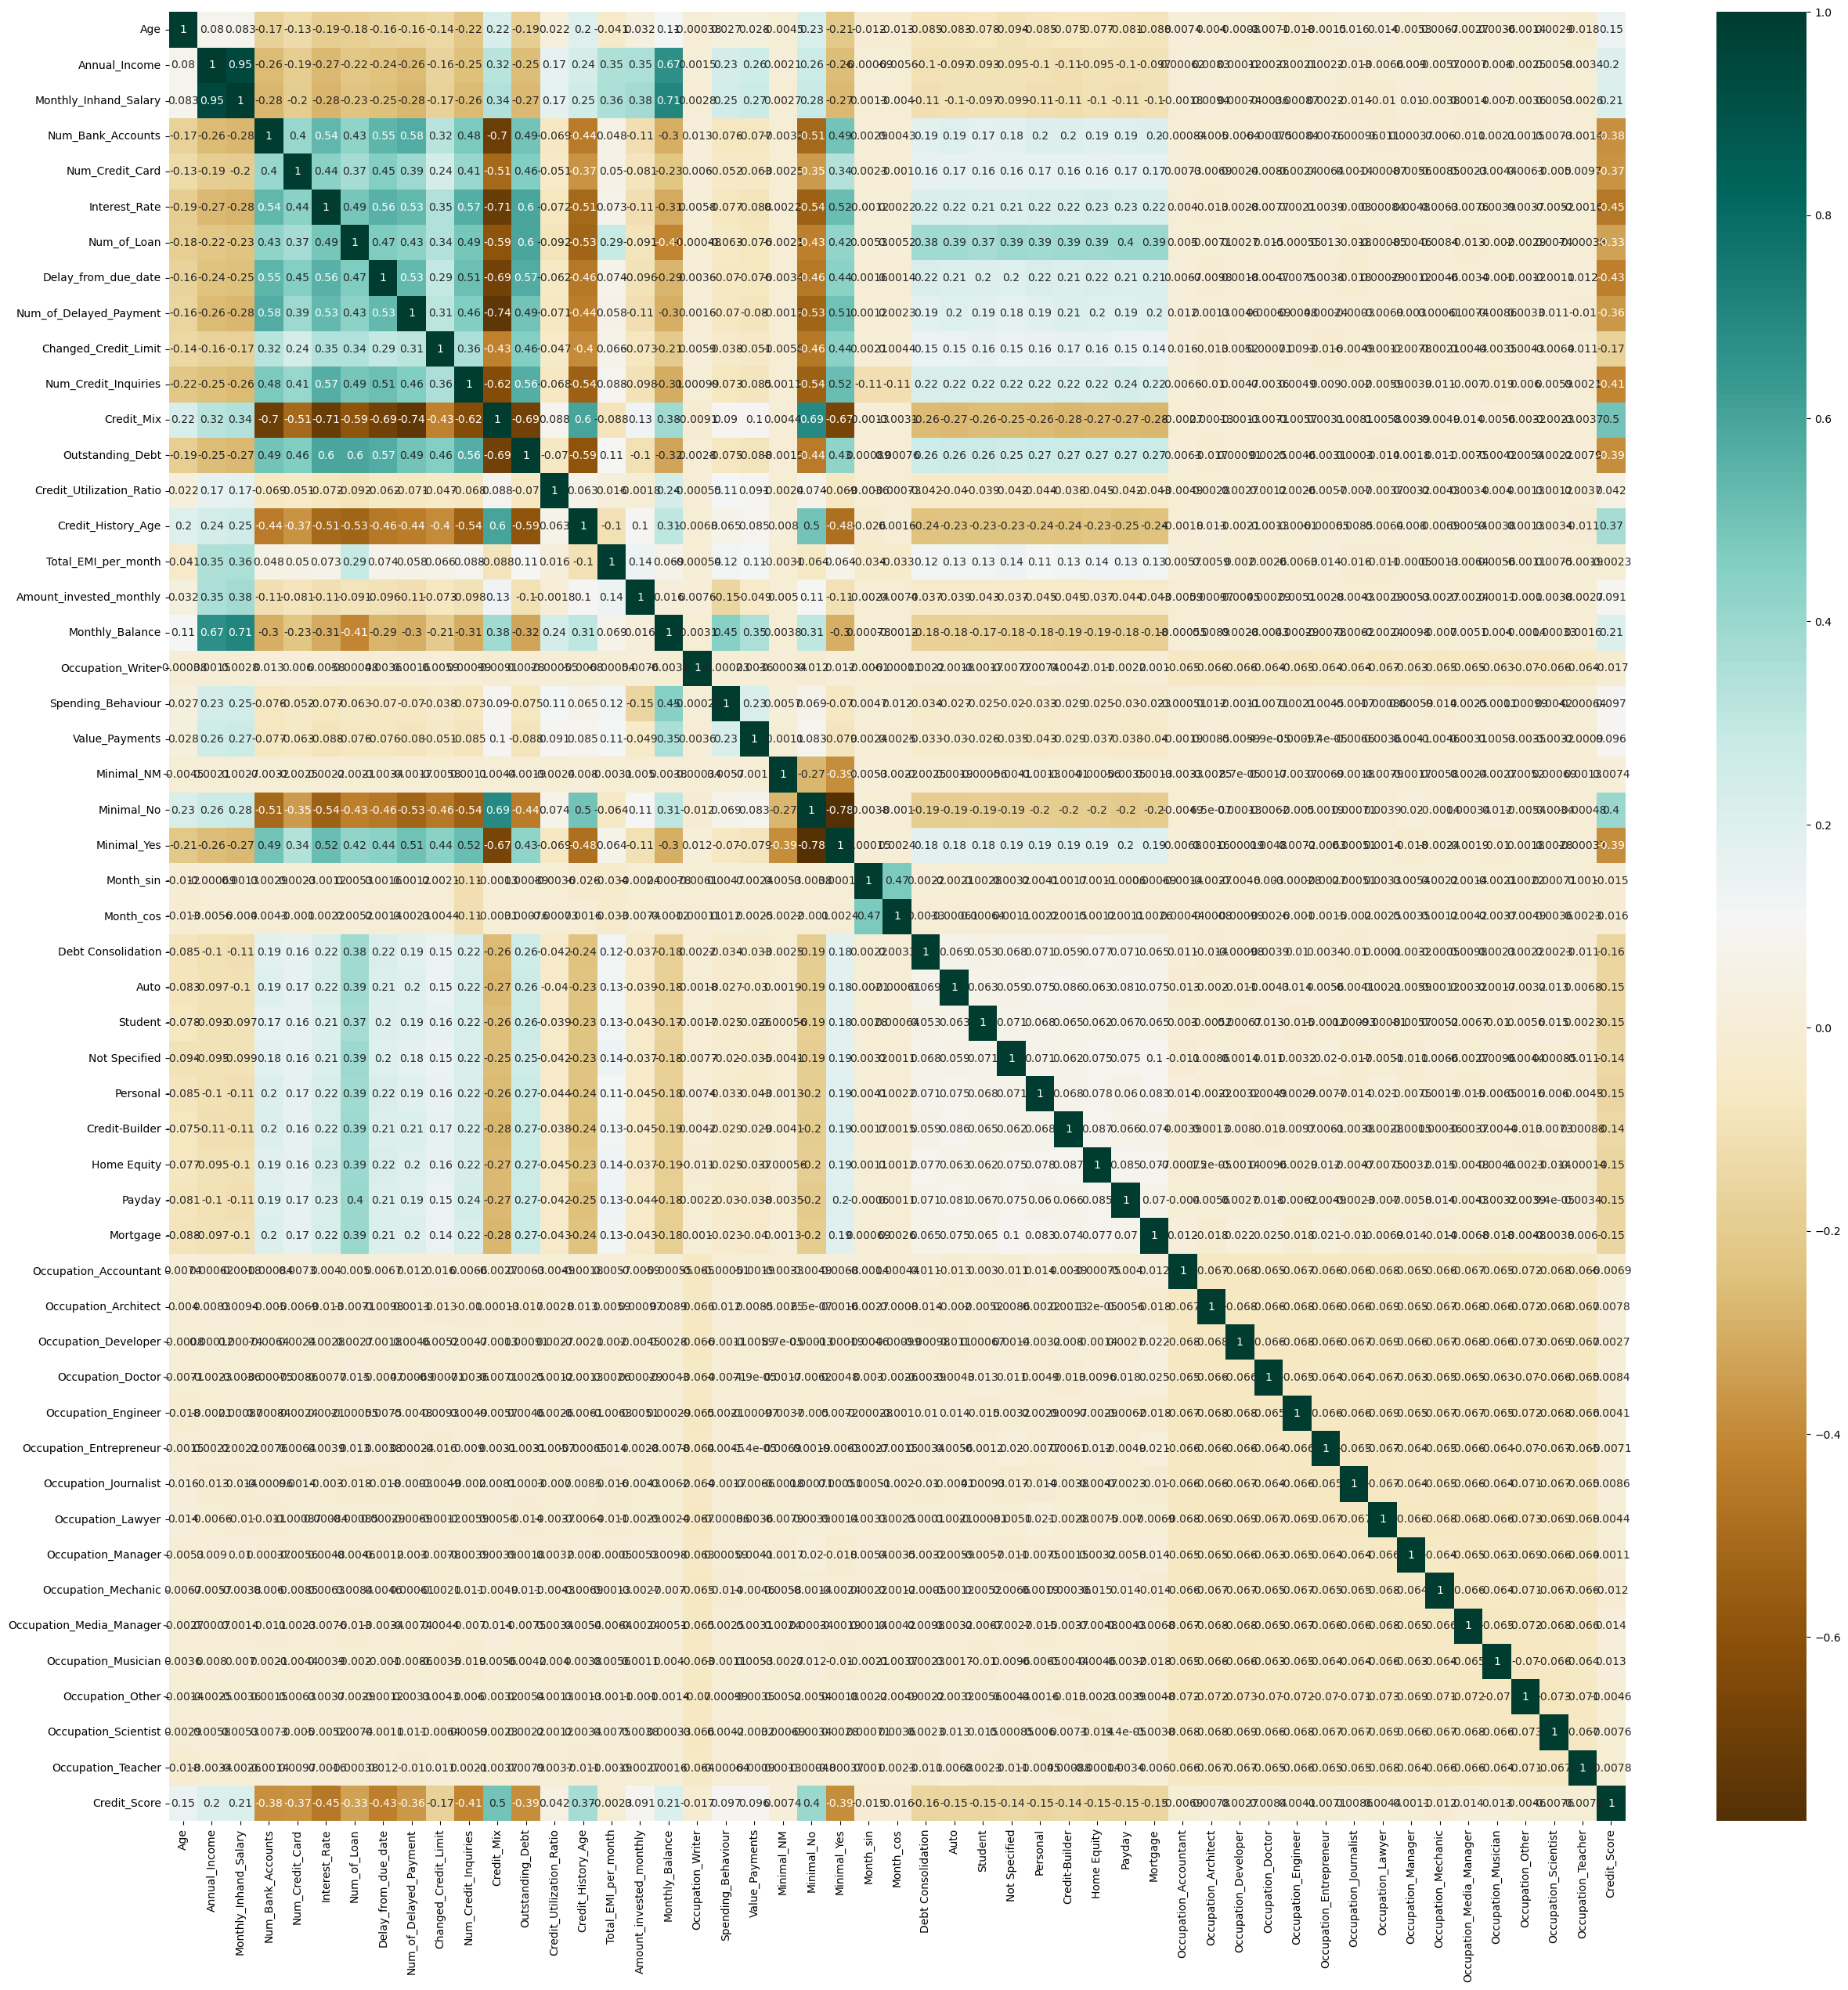

In [32]:
corr_matrix_p = Train_outliers.corr("pearson")
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix_p,cmap="BrBG",annot=True)


Normalizacja

In [33]:
def normal(df):
  df_norm = df.copy()
  norm_col = df_norm.columns.values[:-1]
  scaler_norm = MinMaxScaler()
  for i in df_norm[norm_col]:
    scaler_norm.fit(Train_outliers[[i]])
    df_norm[i] = scaler_norm.transform(df_norm[[i]])

  return df_norm

In [34]:
Train_norm = normal(Train_outliers)
Train_norm.head()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Occupation_Journalist,Occupation_Lawyer,Occupation_Manager,Occupation_Mechanic,Occupation_Media_Manager,Occupation_Musician,Occupation_Other,Occupation_Scientist,Occupation_Teacher,Credit_Score
98425,0.619048,0.205223,0.210518,0.0,0.375,0.290323,0.444444,0.125000,0.32,0.375633,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
20877,0.500000,0.149423,0.149911,0.5,0.500,0.290323,0.444444,0.208333,0.72,0.502073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74091,0.166667,0.074209,0.101126,0.8,0.500,0.322581,0.333333,0.333333,0.72,0.435053,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
9412,0.142857,0.241376,0.236299,0.3,0.250,0.354839,0.333333,0.138889,0.68,0.466605,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
10687,0.285714,0.076607,0.104069,0.8,0.125,0.580645,0.555556,0.152778,0.52,0.482497,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [35]:
def X_y_transform(df):
  y = pd.Series(df['Credit_Score'])
  X = df.drop(['Credit_Score'],axis=1)
  return X,y

In [36]:
X_train,y_train = X_y_transform(Train_norm)

In [37]:
def auc_pred(X,y):
  target = label_binarize(y, classes=[0, 1, 2])
  model = OneVsRestClassifier(LogisticRegression(random_state=0)).fit(X, target)
  prob_test_vec = model.predict_proba(X)

 
  n_classes = 3
  fpr = [0] * 3
  tpr = [0] * 3
  thresholds = [0] * 3
  auc_score = [0] * 3
 
  for i in range(n_classes):
      fpr[i], tpr[i], thresholds[i] = roc_curve(target[:, i], prob_test_vec[:, i])
      auc_score[i] = auc(fpr[i], tpr[i])

  return 2 * (sum(auc_score) / n_classes) - 1

In [38]:
names = X_train.columns.values
#nameses = X_train.columns.values[32:]

for i in names:
  print(i, auc_pred(pd.DataFrame(X_train[i]), y_train))

print("Month_sin Month_cos combined0", auc_pred(X_train[["Month_sin", "Month_cos"]], y_train))
#print(nameses, auc_pred(pd.DataFrame(X_train[nameses]), y_train))

Age 0.11109273682632304
Annual_Income 0.1653638095514509
Monthly_Inhand_Salary 0.1649820784677647
Num_Bank_Accounts 0.28907874944483636
Num_Credit_Card 0.29448736340514503
Interest_Rate 0.3653371092193449
Num_of_Loan 0.26907443939613085
Delay_from_due_date 0.3464532619133933
Num_of_Delayed_Payment 0.288151109627802
Changed_Credit_Limit 0.19009535389334498
Num_Credit_Inquiries 0.35222488441151323
Credit_Mix 0.3811333927563283
Outstanding_Debt 0.3749265465462368
Credit_Utilization_Ratio 0.03156269142433188
Credit_History_Age 0.30809477957710407
Total_EMI_per_month 0.03746085167126645
Amount_invested_monthly 0.08334099805543871
Monthly_Balance 0.18639275337741767
Occupation_Writer 0.00803462352381068
Spending_Behaviour 0.07082732101816402
Value_Payments 0.07461702491204592
Minimal_NM 0.004575967893075017
Minimal_No 0.280561550145193
Minimal_Yes 0.28513751803826803
Month_sin 0.02489870666434868
Month_cos 0.03315711668117394
Debt Consolidation 0.1005546396845085
Auto 0.10518377823170066
Stu

Wyrzucanie kolumn o wysokiej korelacj na podstawie GINI

In [39]:
def drop_corr(df):
  df_drop = df.copy()
  df_drop = df_drop.drop(['Monthly_Inhand_Salary'], axis = 1)
  return df_drop

In [40]:
Train_drop_corr = drop_corr(X_train)

Wyrzucanie kolumn o GINI mniejszym od 0.05

In [41]:
def drop_GINI(df):
  df_drop = df.copy()
  names = Train_drop_corr.columns.values
  for i in names:
     if auc_pred(pd.DataFrame(Train_drop_corr[i]), y_train) < 0.05:
        df_drop = df_drop.drop( [i] , axis = 1)
  return df_drop

In [42]:
X_train = drop_GINI(Train_drop_corr)

In [43]:
def data_preprocessing(X,y):
  df = create_df(X,y)
  df = drop_columns(df)
  df = clean_records(df)
  df = Credit_History_Age_trasform(df)
  df = colums_encoding(df)
  df = encoding_to_num(df)
  df = encoding_columns_2(df)
  df = occupation_agg(df)
  df = swap_columns(df, 'Credit_Score', 'Occupation_Writer')
  df = fill_missing_values(df)
  df = outliers_agg(df)
  df = normal(df)
  df = drop_corr(df)
  df = drop_GINI(df)

  return X_y_transform(df)

In [44]:
X_test, y_test = data_preprocessing(X_test, y_test)


C:\Users\sebas\AppData\Local\Temp\ipykernel_25984\1508392769.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  clean[i] = clean[i].astype(str).str.replace(c,'')


In [45]:
def auc_pred_model(X_test,y_test, X_train, y_train, model):
  y_train = label_binarize(y_train, classes=[0, 1, 2])
  target = label_binarize(y_test, classes=[0, 1, 2])
  model = OneVsRestClassifier(model).fit(X_train, y_train)
  prob_test_vec = model.predict_proba(X_test)

 
  n_classes = 3
  fpr = [0] * 3
  tpr = [0] * 3
  thresholds = [0] * 3
  auc_score = [0] * 3
 
  for i in range(n_classes):
      fpr[i], tpr[i], thresholds[i] = roc_curve(target[:, i], prob_test_vec[:, i])
      auc_score[i] = auc(fpr[i], tpr[i])

  return 2 * (sum(auc_score) / n_classes) - 1

In [46]:
def get_acc_prec_gini(model,X_test,y_test, GINI):
  model.fit(X_train, y_train)
  model_y_pred = model.predict(X_test)
  model_accuracy = accuracy_score(y_test,model_y_pred)
  model_precision = precision_score(y_test, model_y_pred, average = 'weighted')
  if GINI == False:
    return(model_accuracy, model_precision)
  
  GINI = auc_pred_model(X_test,y_test, X_train, y_train, model)
  return(model_accuracy, model_precision, GINI)

Modele

In [47]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=10)
rf_accuracy, rf_precission, rf_GINI = get_acc_prec_gini(rf, X_test, y_test, True)

print("accuracy=",rf_accuracy)
print("precision=",rf_precission) 
print("GINI=", rf_GINI)

accuracy= 0.7864375
precision= 0.7859106052689788
GINI= 0.8142714400084337


In [48]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf_accuracy, sgd_clf_precission = get_acc_prec_gini(sgd_clf, X_test, y_test, False)

print("accuracy=",sgd_clf_accuracy)
print("precision=",sgd_clf_precission) 

accuracy= 0.64875
precision= 0.6577207356119108


In [49]:
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier()
kn_accuracy, kn_precission, kn_GINI = get_acc_prec_gini(kn, X_test, y_test, True)

print("accuracy=",kn_accuracy)
print("precision=",kn_precission) 
print("GINI=", kn_GINI)

C:\Users\sebas\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


accuracy= 0.6826875
precision= 0.678448880478107
GINI= 0.6339394384068271


In [50]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=1)
dt_accuracy, dt_precission, dt_GINI = get_acc_prec_gini(dt, X_test, y_test, True)

print("accuracy=",dt_accuracy)
print("precision=",dt_precission) 
print("GINI=", dt_GINI)

accuracy= 0.6865
precision= 0.6864291967630083
GINI= 0.47298606775893437


In [51]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=1, max_iter=1000)
lr_accuracy, lr_precission, lr_GINI = get_acc_prec_gini(lr, X_test, y_test, True)

print("accuracy=",lr_accuracy)
print("precision=",lr_precission) 
print("GINI=", lr_GINI)

accuracy= 0.6535
precision= 0.6554398248318735
GINI= 0.5891936267775977


In [52]:
from sklearn.ensemble import VotingClassifier
estimators=[('DecisionTree', dt), ('KNN', kn), ('LR', lr)]

In [53]:
hv = VotingClassifier(estimators=estimators, voting='hard')
hv_accuracy, hv_precission = get_acc_prec_gini(hv, X_test, y_test, False)

print("accuracy=",hv_accuracy)
print("precision=",hv_precission) 

C:\Users\sebas\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


accuracy= 0.716
precision= 0.7144620873977756


In [54]:
sv = VotingClassifier(estimators=estimators, voting='soft')
sv_accuracy, sv_precission = get_acc_prec_gini(sv, X_test, y_test, False)

print("accuracy=",sv_accuracy)
print("precision=",sv_precission) 

accuracy= 0.7244375
precision= 0.7226212724332771


In [55]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

xgb_accuracy, xgb_precission = get_acc_prec_gini(xgb, X_test, y_test, False)
print("accuracy=",xgb_accuracy)
print("precision=",xgb_precission)

accuracy= 0.7470625
precision= 0.7475564757564126


In [56]:
from sklearn.ensemble import BaggingClassifier
bc = BaggingClassifier()
bc_accuracy, bc_precission, bc_GINI = get_acc_prec_gini(bc, X_test, y_test, True)

print("accuracy=",bc_accuracy)
print("precision=",bc_precission) 
print("GINI=", bc_GINI)

accuracy= 0.756125
precision= 0.7553107012159407
GINI= 0.759244273544228


Wybór najlepszego modelu

In [57]:
models = {
 'rf': rf,
 'sgd_clf': sgd_clf,
 'kn': kn,
 'dt': dt,
 'lr': lr,
 'hv': hv,
 'sv': sv,
 'xgb': xgb,
 'bc': bc}

In [58]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
def evaluate_model(model, X, y):
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

    return scores

In [59]:
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('%8s mean-%.3f std-%.3f' % (name, np.mean(scores), np.std(scores)))

      rf mean-0.788 std-0.004
 sgd_clf mean-0.646 std-0.007
      kn mean-0.683 std-0.006
      dt mean-0.695 std-0.005
      lr mean-0.652 std-0.006
      hv mean-0.716 std-0.006
      sv mean-0.727 std-0.004
     xgb mean-0.750 std-0.004
      bc mean-0.765 std-0.004


Strojenie hiperparametrów

In [61]:
from sklearn.model_selection import GridSearchCV
param_grid = {
 'max_depth': [50, 60, 70, 80, 90],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 600, 1100, 1600, 2100]}

In [62]:
forest_model = RandomForestClassifier()
grid = GridSearchCV(estimator = forest_model, param_grid = param_grid, cv = 3, n_jobs=-1)

grid_result = grid.fit(X_train, y_train) 

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.780641 using {'max_depth': 70, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2100}


In [68]:
from sklearn.model_selection import GridSearchCV
param_grid_2 = {
 'max_depth': [70],
 'min_samples_leaf': [1],
 'min_samples_split': [2],
 'n_estimators': [1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600]}

In [69]:
forest_model = RandomForestClassifier()
grid_2 = GridSearchCV(estimator = forest_model, param_grid = param_grid_2, cv = 3, n_jobs=-1)

grid_result_2 = grid_2.fit(X_train, y_train) 

print("Best: %f using %s" % (grid_result_2.best_score_, grid_result_2.best_params_))

Best: 0.780687 using {'max_depth': 70, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1900}


In [70]:
from sklearn.model_selection import GridSearchCV
param_grid_3 = {
 'max_depth': [60,62,64,66,68,70,72,74,76,78,80],
 'min_samples_leaf': [1],
 'min_samples_split': [2],
 'n_estimators': [1900]}

In [71]:
forest_model = RandomForestClassifier()
grid_3 = GridSearchCV(estimator = forest_model, param_grid = param_grid_3, cv = 3, n_jobs=-1)

grid_result_3 = grid_3.fit(X_train, y_train) 

print("Best: %f using %s" % (grid_result_3.best_score_, grid_result_3.best_params_))

Best: 0.780984 using {'max_depth': 64, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1900}


Ostateczny model

In [72]:
from sklearn.ensemble import RandomForestClassifier
rf2 = RandomForestClassifier(n_estimators = 1900,max_depth = 64)
rf_accuracy, rf_precission, rf_GINI = get_acc_prec_gini(rf2, X_test, y_test, True)

print("accuracy=",rf_accuracy)
print("precision=",rf_precission) 
print("GINI=", rf_GINI)

accuracy= 0.7886875
precision= 0.7882742479079677
GINI= 0.8214502273568574
